In [244]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
# List of CSV files and their corresponding table names

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')
]
 # Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Akash@230993',
    database='E_Commerce'
)
cursor = conn.cursor()

# folder containing csv files
folder_path = 'C:/Only For me/MY/Data Analytics/Projects/Python/E-Commers'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



In [28]:
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Akash@230993',
    database='E_Commerce'
    )
cur = db.cursor()

# List all unique cities where customers are located.

In [87]:
query=""" SELECT DISTINCT customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [50]:
query=""" SELECT COUNT(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)
data = cur.fetchall()
'Total orders placed in 2017 are',data[0][0]

('Total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [85]:
query=""" SELECT products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Sale"])
df

,Category,Sale
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.


In [104]:
query=""" SELECT sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Percentage"])
df

,Percentage
0,99.9981


# Count the number of customers from each state. 


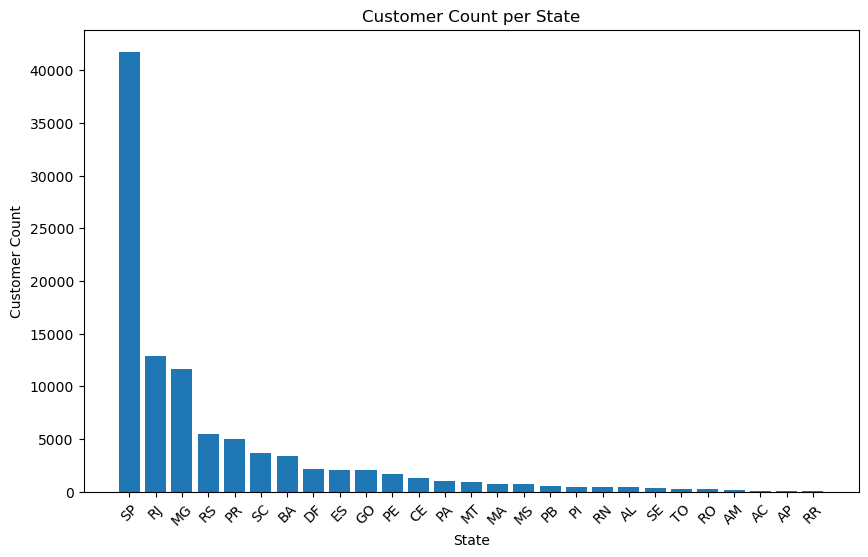

In [133]:
query=""" SELECT customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State","Customer_count"])
df = df.sort_values(by = "Customer_count",ascending= False)
plt.figure(figsize=(10, 6))  # Optional: set the figure size
plt.bar(df["State"], df["Customer_count"])
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Customer Count per State")
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.show()

# Calculate the number of orders per month in 2018.


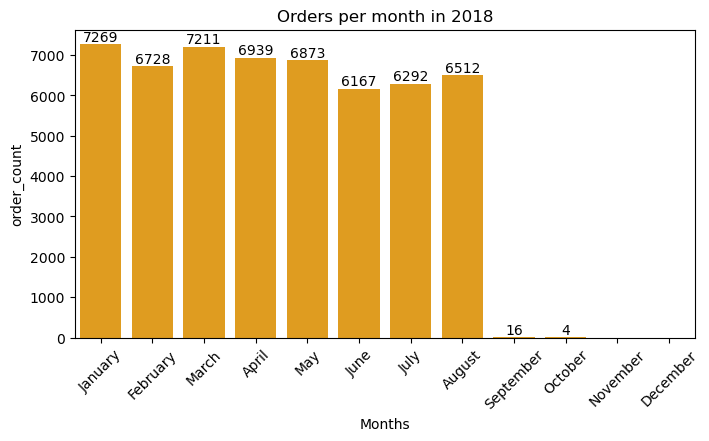

In [170]:
query=""" SELECT monthname(order_purchase_timestamp) Months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by Months
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","order_count"])
o = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]

plt.figure(figsize=(8, 4))  
ax = sns.barplot(x= df["Months"], y = df["order_count"],data= df, order = o, color = "orange")
ax.bar_label(ax.containers[0])
plt.title("Orders per month in 2018")
plt.xticks(rotation=45) 
plt.show()

# Find the average number of products per order, grouped by customer city.


In [193]:
query = """ with count_per_order as
(SELECT orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items on
orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order on
customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_city","average_products_per_orders"] )
df.head(10)

,customer_city,average_products_per_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.


In [216]:
query = """SELECT upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments)*100),2) sales_percentage
from products 
join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category","Percentage_distribution"])
df.head()

,Category,Percentage_distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.


In [228]:
query = """
Select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category","order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.


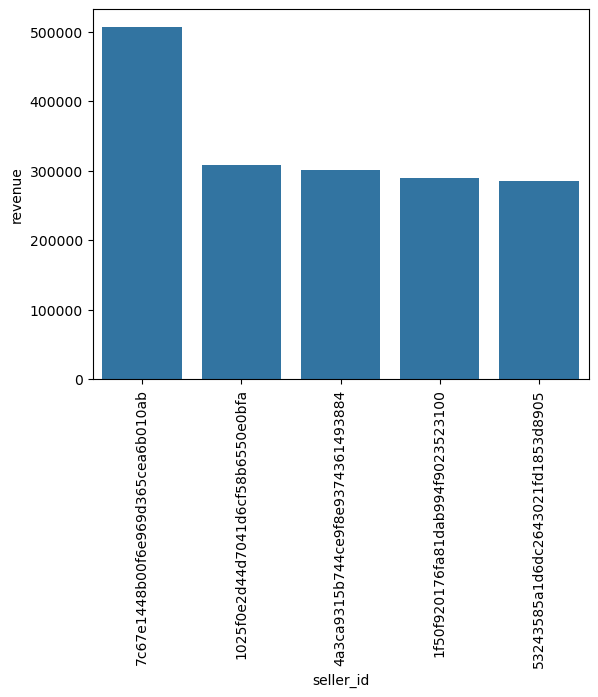

In [256]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id )as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "Rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation=90) 
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [270]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders 
on payments.order_id = orders.order_id) as Sub
"""
cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","payment","mov_avg"])
df.head()

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.


In [273]:
query = """ select years, months, payment, sum(payment)
over(order by years,months) cummulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years, months) as sub
"""
cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment","cummulative_sales"])
df.head()

,years,months,payment,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.


In [286]:
query = """with sub as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from sub

"""
cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data,columns =["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [295]:
query = """ with a as ( select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders 
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""

cur.execute(query)
data =cur.fetchall()
data
# none of the customers by buy again

[(None,)]

# Identify the top 3 customers who spent the most money in each year.


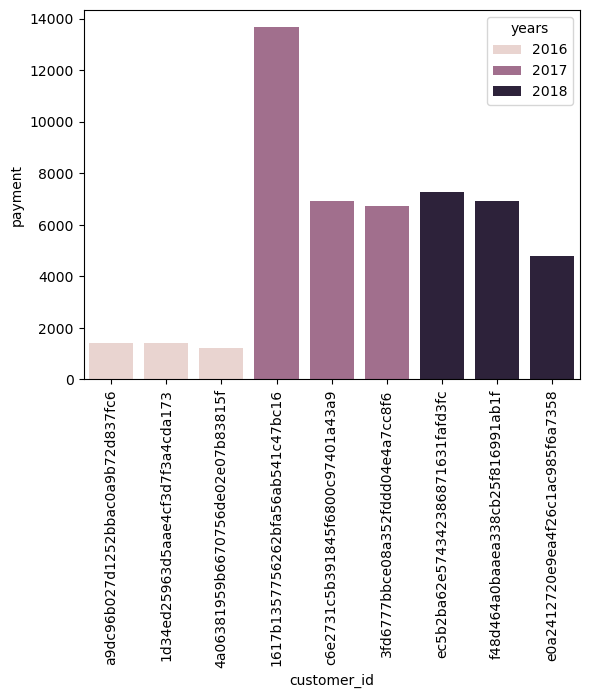

In [304]:
query= """ select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3 """

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data,columns =["years","customer_id","payment","d_rank"])
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation=90)
plt.show()